# Sodium Voltage-gated Channel, Alpha Subunit 2 (SCN2A) and Associated Syndrome

[Sodium Voltage-gated Channel, Alpha Subunit 2 (SCN2A)](https://www.omim.org/entry/182390) is a gene that encodes the voltage-gated sodium channel Na(v)1.2. This effects the initiation and conduction of action potentials in unmyelinated axons. 

There are three known syndromes associated with pathogenic variants on SCN2A, two of which are included in this analysis. 

[Developmental and epileptic encephalopathy 11](https://www.omim.org/entry/613721) is an autosomal dominant disease, with onset in infancy. It is characterized by seizures, developmental delay, status epilepticus, abnormal movements, autistic features, and many other neurological phenotypes, microcephaly, and oculogyric crises. The severity of this disease varies significantly among individuals. 

[Seizures, benign familial infantile, 3](https://www.omim.org/entry/607745) is an autosomal dominant disease, with onset within 7 months of birth. It is characterized by seizures, apnea during seizures, staring episodes during seizures, and cyanosis. 

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

Several previous publications have reported candidate genotype-phenotype correlations for variants on SCN2A.

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Reynolds et al. (2020)](https://www.sciencedirect.com/science/article/pii/S1090379819304362) stated that:

> "There are two recurrent variants identified in this cohort [individuals with neonatal seizures and later onset episodic ataxia], p.Ala263Val and p.Arg1882Gly."

> "Missense variants in SCN2A, causing a GOF are identified in cohorts with BFNIS (Benign familial neonatal-infantile seizures) and DEE (Developmental and epileptic encephalopathies) onset <3 months."

[Wolff et al. (2020)](https://onlinelibrary.wiley.com/doi/full/10.1111/epi.14935) stated that:

> "The R853Q (S4 domain 2) variant was found in patients often presenting with West syndrome, severe intellectual disability, intractable seizures, and choreoathetosis."

> "SCN2A variants in the subgroup of ID/ASD are mainly truncating (75%), with missense variants occurring in 25%."


Therefore, we tested missense vs other variants, p.Arg853Gln vs all others, those in domain 2 vs anywhere else, and p.Ala263Val & p.Arg1882Gly vs all others. 

# Imports 

In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.9.1.dev0


### SCN2A
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SCN2A.

In [3]:
gene_symbol = 'SCN2A'
mane_tx_id = 'NM_021007.3'
mane_protein_id = 'NP_066287.2'

In [4]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.21'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals from {gene_symbol} cohort')
qc.summarize()

Loaded 393 phenopackets
Individuals Processed: 100%|██████████| 393/393 [08:13<00:00,  1.25s/individuals]
Loaded 393 individuals from SCN2A cohort
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
127,Epileptic encephalopathy
97,"Intellectual disability, severe"
92,Autism
86,Bilateral tonic-clonic seizure
84,Global developmental delay
74,Multifocal epileptiform discharges
74,Seizure
72,Generalized tonic seizure
69,Hypotonia
64,Infantile spasms


## Protein sequence effects

Summarize effects on the protein sequence

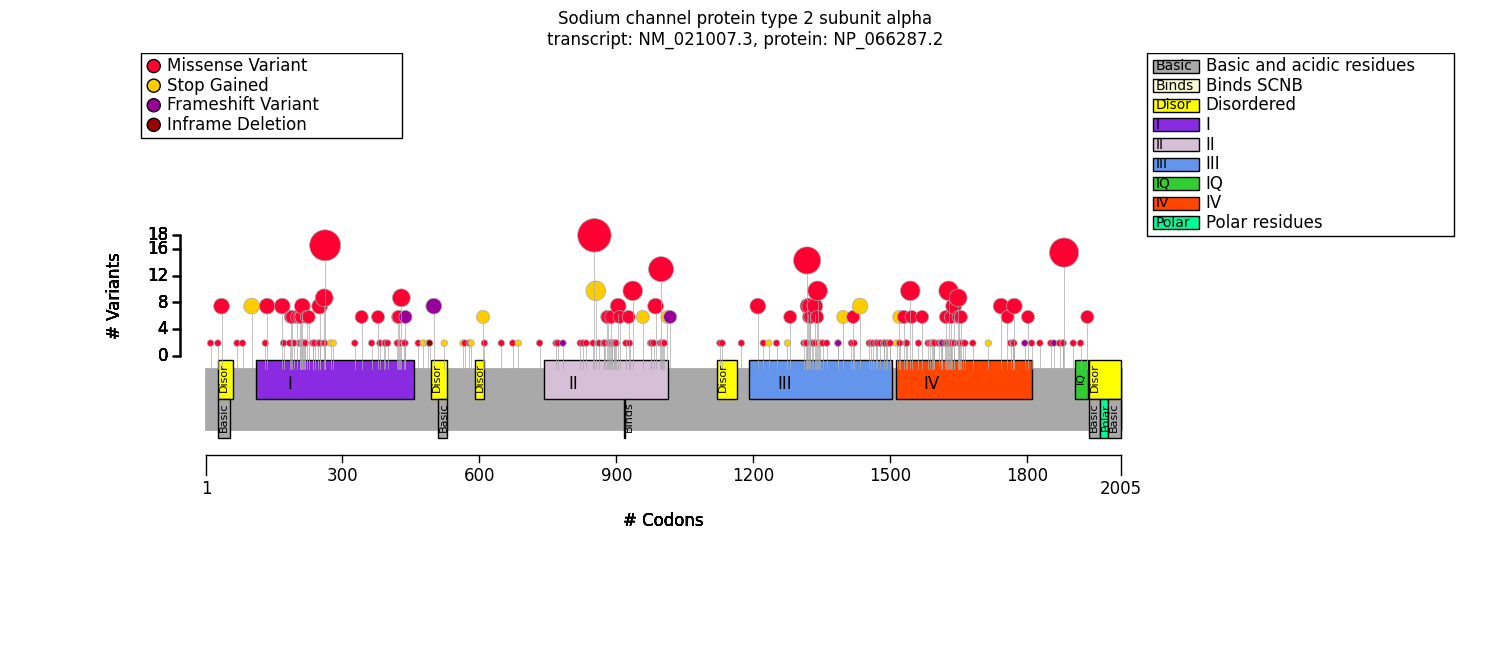

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
scn2a_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
scn2a_fig.tight_layout()

In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
display(report)

Count,Variant key,HGVS,Overlapping Exons,Effects
18,2_165342465_165342465_G_A,c.2558G>A (p.Arg853Gln),15,missense
14,2_165310413_165310413_C_T,c.788C>T (p.Ala263Val),7,missense
10,2_165389451_165389451_G_A,c.5645G>A (p.Arg1882Gln),27,missense
8,2_165354267_165354267_G_A,c.2995G>A (p.Glu999Lys),17,missense
5,2_165373331_165373331_G_A,c.3956G>A (p.Arg1319Gln),21,missense
5,2_165374737_165374737_T_C,c.4025T>C (p.Leu1342Pro),22,missense
4,2_165386827_165386827_A_G,c.4633A>G (p.Met1545Val),26,missense
4,2_165388692_165388692_G_A,c.4886G>A (p.Arg1629His),27,missense
4,2_165310406_165310406_G_A,c.781G>A (p.Val261Met),7,missense
4,2_165388755_165388755_T_C,c.4949T>C (p.Leu1650Pro),27,missense


In [8]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
3,Disordered,Region,29 - 61,p.Arg36Gly
3,Basic and acidic residues,Compositional bias,29 - 53,p.Arg36Gly
87,I,Repeat,112 - 456,p.Val213Ala; p.Ala263Val; p.Trp191Gly; p.Asn132Lys; p.Glu430Gly; p.Thr365Met; p.Glu438Asp; p.Val261Met; p.Thr236Ser; p.Glu430Ala; p.Phe328Val; p.Val213Asp; p.Thr227Ile; p.Val424Leu; p.Leu248Pro; p.Gly211Asp; p.Glu430Gln; p.Glu169Ter; p.Arg395Pro; p.Ile237Asn; p.Ala202Val; p.Val424Met; p.Trp281Ter; p.Glu440ArgfsTer20; p.Met252Val; p.Thr400Arg; p.Phe262Ser; p.Leu436Ser; p.Arg379His; p.Glu169Gly; p.Val208Glu; p.Tyr428Cys; p.Leu421Val; p.Ala439Ter; p.Arg220Gly; p.Leu216Trp; p.Arg223Gln; p.Ser214Pro; p.Gln383Glu; p.Phe207Ser; p.Asn212Asp; p.Asp343Gly; p.Val251Ala; p.Ala240Ser; p.Thr393Lys; p.Val251Ile; p.Val423Leu; p.Met136Ile; p.Arg188Trp; p.Ile172Val; p.Ala263Thr; p.Arg275Ter; p.Trp191Cys; p.Thr185Ile; p.Asp195Gly; p.Thr218Lys
4,Disordered,Region,495 - 529,p.Asn503LysfsTer19; p.Leu501Ter; p.Arg524Ter
1,Basic and acidic residues,Compositional bias,511 - 529,p.Arg524Ter
2,Disordered,Region,591 - 610,p.Asp609Ter; p.Leu611ValfsTer35
85,II,Repeat,742 - 1013,p.Arg937Cys; p.Ile873Met; p.Arg856Ter; p.Gly828Val; p.Leu881Pro; p.Lys908Glu; p.Glu999Val; p.Phe895Ser; p.Ile890Met; p.Phe928Cys; p.Arg856Leu; p.Leu835Phe; p.Gln901Glu; p.Arg850Pro; p.Glu999Lys; p.Arg856Gln; p.Ser863Phe; p.Gly899Ser; p.Gly882Glu; p.Leu983Trp; p.Gly882Arg; p.Thr773Ile; p.Asn976Lys; p.Gly1013Ter; p.Ala1006Val; p.Cys959Ter; p.Arg853Gln; p.Arg937His; p.Asn876Thr; p.Arg922Cys; p.Leu884His; p.His930Gln; p.Lys905Asn; p.Asn1001Lys; p.Lys905Gln; p.Ile891Thr; p.Ala896Val; p.Ile769Thr; p.Thr784CysfsTer45; p.Val887Ala; p.Leu1003Ile; p.Ser987Ile; p.Ile874MetfsTer5; p.Asp997Tyr; p.Phe978Leu; p.Val892Ile; p.Gly822Ser
0,Binds SCN2B,Region,918 - 918,
2,Disordered,Region,1121 - 1165,p.Met1128Thr; p.Glu1133Asp
73,III,Repeat,1191 - 1504,p.Val1326Leu; p.Val1325Ile; p.Leu1341Ile; p.Arg1312Thr; p.Ala1316Val; p.Trp1276Ter; p.Arg1319Trp; p.Met1338Thr; p.Glu1493del; p.Lys1362Met; p.Val1325Phe; p.Lys1495Glu; p.Ile1473Met; p.Cys1386Arg; p.Ala1500Thr; p.Thr1420Met; p.Met1501Val; p.Val1282Phe; p.Asp1487Glu; p.Arg1319Pro; p.Leu1330Phe; p.Ser1318Pro; p.Ile1455Asn; p.Glu1211Lys; p.Ile1488Asn; p.Leu1342Pro; p.Arg1235Ter; p.Arg1319Gln; p.Ser1336Tyr; p.Trp1398Ter; p.Cys1344Tyr; p.Gly1460Arg; p.Lys1422Glu; p.Arg1435Ter; p.Ile1252Val; p.Trp1348Ter; p.Lys1387SerfsTer4; p.Thr1464Ala; p.Gly1223Arg; p.Gly1470Ala; p.Ala1333Thr; p.Arg1319Leu; p.Met1323Val; p.Ile1353Met; p.Glu1321Lys; p.Val1326Asp; p.Gln1479Pro; p.Leu1341Arg; p.Leu1416Phe


# Genotype-Phenotype Correlation (GPC) Analysis

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect 
from gpsea.analysis.clf import monoallelic_classifier 
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,142
HMF08,Skipping general term,96
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,322


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense          Other  \
                                                      Count Percent  Count   
Motor seizure [HP:0020219]                          146/175     83%   6/31   
Focal-onset seizure [HP:0007359]                    141/170     83%   8/33   
Seizure [HP:0001250]                                298/327     91%  28/53   
Generalized-onset seizure [HP:0002197]              104/133     78%   6/31   
Autism [HP:0000717]                                  59/146     40%  33/43   
Intellectual disability [HP:0001249]                144/198     73%  34/34   
Neurodevelopmental abnormality [HP:0012759]         201/238     84%  45/45   
Interictal epileptiform activity [HP:0011182]       172/200     86%  12/17   
Interictal EEG abnormality [HP:0025373]             172/199     86%  13/18   
EEG abnormality [HP:0002353]                        183/210     87%  14/19   
Abnormal muscle tone [HP:0003808]                   104/145     72%  10/18   
Abnormal cerebral morphology [HP:0002060]            85/181     47%   6/19   
Abnormal forebrain morphology [HP:0100547]           85/181     47%   6/19   
Abnormal brain morphology [HP:0012443]              105/201     52%  10/23   
Abnormality of central nervous system electroph...  183/183    100%  14/14   

Allele group                                                                   \
                                                   Percent Corrected p values   
Motor seizure [HP:0020219]                             19%       6.766468e-11   
Focal-onset seizure [HP:0007359]                       24%       6.493900e-10   
Seizure [HP:0001250]                                   53%       7.857431e-10   
Generalized-onset seizure [HP:0002197]                 19%       5.366477e-09   
Autism [HP:0000717]                                    77%       8.073898e-05   
Intellectual disability [HP:0001249]                  100%       2.346729e-04   
Neurodevelopmental abnormality [HP:0012759]           100%       2.993939e-03   
Interictal epileptiform activity [HP:0011182]          71%       2.342889e-01   
Interictal EEG abnormality [HP:0025373]                72%       2.342889e-01   
EEG abnormality [HP:0002353]                           74%       2.342889e-01   
Abnormal muscle tone [HP:0003808]                      56%       2.426775e-01   
Abnormal cerebral morphology [HP:0002060]              32%       2.687489e-01   
Abnormal forebrain morphology [HP:0100547]             32%       2.687489e-01   
Abnormal brain morphology [HP:0012443]                 43%       5.474991e-01   
Abnormality of central nervous system electroph...    100%       1.000000e+00   

Allele group                                                      
                                                        p values  
Motor seizure [HP:0020219]                          4.510979e-12  
Focal-onset seizure [HP:0007359]                    8.658533e-11  
Seizure [HP:0001250]                                1.571486e-10  
Generalized-onset seizure [HP:0002197]              1.431061e-09  
Autism [HP:0000717]                                 2.691299e-05  
Intellectual disability [HP:0001249]                9.386915e-05  
Neurodevelopmental abnormality [HP:0012759]         1.397172e-03  
Interictal epileptiform activity [HP:0011182]       1.484832e-01  
Interictal EEG abnormality [HP:0025373]             1.544847e-01  
EEG abnormality [HP:0002353]                        1.561926e-01  
Abnormal muscle tone [HP:0003808]                   1.779635e-01  
Abnormal cerebral morphology [HP:0002060]           2.329157e-01  
Abnormal forebrain morphology [HP:0100547]          2.329157e-01  
Abnormal brain morphology [HP:0012443]              5.109992e-01  
Abnormality of central nervous system electroph...  1.000000e+00

In [13]:
from gpsea.analysis.predicate import protein_feature

i_repeat = protein_feature(feature_id="I", protein_metadata=protein_meta)

i_predicate = monoallelic_classifier(
    a_predicate=i_repeat,
    b_predicate=~i_repeat,
    a_label="I repeat",
    b_label="Other"
)

i_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=i_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=i_result)

Allele group                                       I repeat            Other  \
                                                      Count Percent    Count   
Intellectual disability [HP:0001249]                  21/42     50%  157/190   
Neurodevelopmental abnormality [HP:0012759]           48/65     74%  198/218   
Focal-onset seizure [HP:0007359]                      39/46     85%  110/157   
Motor seizure [HP:0020219]                            39/46     85%  113/160   
Seizure [HP:0001250]                                  79/86     92%  247/294   
Autism [HP:0000717]                                   11/32     34%   81/157   
Generalized-onset seizure [HP:0002197]                27/34     79%   83/130   
EEG abnormality [HP:0002353]                          48/57     84%  149/172   
Interictal EEG abnormality [HP:0025373]               47/56     84%  138/161   
Interictal epileptiform activity [HP:0011182]         47/56     84%  137/161   
Abnormal muscle tone [HP:0003808]                     31/43     72%   83/120   
Abnormal cerebral morphology [HP:0002060]             21/48     44%   70/152   
Abnormal forebrain morphology [HP:0100547]            21/48     44%   70/152   
Abnormality of central nervous system electroph...    48/48    100%  149/149   
Abnormal brain morphology [HP:0012443]                28/55     51%   87/169   

Allele group                                                                   \
                                                   Percent Corrected p values   
Intellectual disability [HP:0001249]                   83%           0.000389   
Neurodevelopmental abnormality [HP:0012759]            91%           0.008888   
Focal-onset seizure [HP:0007359]                       70%           0.209458   
Motor seizure [HP:0020219]                             71%           0.209458   
Seizure [HP:0001250]                                   84%           0.209458   
Autism [HP:0000717]                                    52%           0.209458   
Generalized-onset seizure [HP:0002197]                 64%           0.220039   
EEG abnormality [HP:0002353]                           87%           1.000000   
Interictal EEG abnormality [HP:0025373]                86%           1.000000   
Interictal epileptiform activity [HP:0011182]          85%           1.000000   
Abnormal muscle tone [HP:0003808]                      69%           1.000000   
Abnormal cerebral morphology [HP:0002060]              46%           1.000000   
Abnormal forebrain morphology [HP:0100547]             46%           1.000000   
Abnormality of central nervous system electroph...    100%           1.000000   
Abnormal brain morphology [HP:0012443]                 51%           1.000000   

Allele group                                                  
                                                    p values  
Intellectual disability [HP:0001249]                0.000026  
Neurodevelopmental abnormality [HP:0012759]         0.001185  
Focal-onset seizure [HP:0007359]                    0.057492  
Motor seizure [HP:0020219]                          0.058945  
Seizure [HP:0001250]                                0.078884  
Autism [HP:0000717]                                 0.083783  
Generalized-onset seizure [HP:0002197]              0.102685  
EEG abnormality [HP:0002353]                        0.661958  
Interictal EEG abnormality [HP:0025373]             0.827052  
Interictal epileptiform activity [HP:0011182]       0.830941  
Abnormal muscle tone [HP:0003808]                   0.846806  
Abnormal cerebral morphology [HP:0002060]           0.868345  
Abnormal forebrain morphology [HP:0100547]          0.868345  
Abnormality of central nervous system electroph...  1.000000  
Abnormal brain morphology [HP:0012443]              1.000000

In [14]:
from gpsea.analysis.predicate import variant_key

arg853gln = variant_key("2_165342465_165342465_G_A")  # c.2558G>A	p.Arg853Gln
arg853gln_predicate = monoallelic_classifier(
    a_predicate=arg853gln,
    b_predicate=~arg853gln,
    a_label="Arg853Gln",
    b_label="Other"
)
arg853gln_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg853gln_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=arg853gln_result)

Allele group                                       Arg853Gln            Other  \
                                                       Count Percent    Count   
Generalized-onset seizure [HP:0002197]                   9/9    100%  101/155   
Motor seizure [HP:0020219]                             12/12    100%  140/194   
Intellectual disability [HP:0001249]                   14/14    100%  164/218   
Abnormal muscle tone [HP:0003808]                        7/7    100%  107/156   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]         7/12     58%   50/154   
Seizure [HP:0001250]                                   17/17    100%  309/363   
Abnormal cerebral morphology [HP:0002060]               9/14     64%   82/186   
Abnormal forebrain morphology [HP:0100547]              9/14     64%   82/186   
Interictal epileptiform activity [HP:0011182]          12/12    100%  172/205   
Interictal EEG abnormality [HP:0025373]                12/12    100%  173/205   
EEG abnormality [HP:0002353]                           12/12    100%  185/217   
Neurodevelopmental abnormality [HP:0012759]            15/15    100%  231/268   
Focal-onset seizure [HP:0007359]                         5/5    100%  144/198   
Abnormal brain morphology [HP:0012443]                  9/14     64%  106/210   
Autism [HP:0000717]                                     4/10     40%   88/179   
Abnormality of central nervous system electroph...     12/12    100%  185/185   

Allele group                                                                   \
                                                   Percent Corrected p values   
Generalized-onset seizure [HP:0002197]                 65%           0.235813   
Motor seizure [HP:0020219]                             72%           0.235813   
Intellectual disability [HP:0001249]                   75%           0.235813   
Abnormal muscle tone [HP:0003808]                      69%           0.309446   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]        32%           0.309446   
Seizure [HP:0001250]                                   85%           0.309446   
Abnormal cerebral morphology [HP:0002060]              44%           0.309446   
Abnormal forebrain morphology [HP:0100547]             44%           0.309446   
Interictal epileptiform activity [HP:0011182]          84%           0.309446   
Interictal EEG abnormality [HP:0025373]                84%           0.309446   
EEG abnormality [HP:0002353]                           85%           0.309446   
Neurodevelopmental abnormality [HP:0012759]            86%           0.309446   
Focal-onset seizure [HP:0007359]                       73%           0.403247   
Abnormal brain morphology [HP:0012443]                 50%           0.469948   
Autism [HP:0000717]                                    49%           0.797938   
Abnormality of central nervous system electroph...    100%           1.000000   

Allele group                                                  
                                                    p values  
Generalized-onset seizure [HP:0002197]              0.030795  
Motor seizure [HP:0020219]                          0.038768  
Intellectual disability [HP:0001249]                0.044215  
Abnormal muscle tone [HP:0003808]                   0.103527  
Aplasia/Hypoplasia of the cerebrum [HP:0007364]     0.110542  
Seizure [HP:0001250]                                0.146802  
Abnormal cerebral morphology [HP:0002060]           0.170426  
Abnormal forebrain morphology [HP:0100547]          0.170426  
Interictal epileptiform activity [HP:0011182]       0.220643  
Interictal EEG abnormality [HP:0025373]             0.221401  
EEG abnormality [HP:0002353]                        0.225699  
Neurodevelopmental abnormality [HP:0012759]         0.232085  
Focal-onset seizure [HP:0007359]                    0.327638  
Abnormal brain morphology [HP:0012443]              0.411205  
Autism [HP:0000717]                                 0.748067  
Abnormality

In [15]:
from gpsea.analysis.predicate import exon

# Exon 27 is commonly mutated
ex27 = exon(exon=27, tx_id=mane_tx_id)
ex27_predicate = monoallelic_classifier(
    a_predicate=ex27,
    b_predicate=~ex27,
    a_label="Exon 27",
    b_label="Other"
)
ex27_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ex27_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=ex27_result)

Allele group                                       Exon 27            Other  \
                                                     Count Percent    Count   
Interictal epileptiform activity [HP:0011182]        33/46     72%  151/171   
EEG abnormality [HP:0002353]                         33/45     73%  164/184   
Neurodevelopmental abnormality [HP:0012759]          57/59     97%  189/224   
Interictal EEG abnormality [HP:0025373]              33/45     73%  152/172   
Intellectual disability [HP:0001249]                 44/50     88%  134/182   
Abnormal muscle tone [HP:0003808]                    31/40     78%   83/123   
Generalized-onset seizure [HP:0002197]               23/33     70%   87/131   
Focal-onset seizure [HP:0007359]                     26/36     72%  123/167   
Abnormality of central nervous system electroph...   33/33    100%  164/164   
Motor seizure [HP:0020219]                           28/38     74%  124/168   
Seizure [HP:0001250]                                 60/70     86%  266/310   
Abnormal cerebral morphology [HP:0002060]            20/43     47%   71/157   
Abnormal forebrain morphology [HP:0100547]           20/43     47%   71/157   
Abnormal brain morphology [HP:0012443]               25/48     52%   90/176   
Autism [HP:0000717]                                  18/36     50%   74/153   

Allele group                                                                   \
                                                   Percent Corrected p values   
Interictal epileptiform activity [HP:0011182]          88%           0.064959   
EEG abnormality [HP:0002353]                           89%           0.064959   
Neurodevelopmental abnormality [HP:0012759]            84%           0.064959   
Interictal EEG abnormality [HP:0025373]                88%           0.064959   
Intellectual disability [HP:0001249]                   74%           0.112422   
Abnormal muscle tone [HP:0003808]                      67%           0.802083   
Generalized-onset seizure [HP:0002197]                 66%           1.000000   
Focal-onset seizure [HP:0007359]                       74%           1.000000   
Abnormality of central nervous system electroph...    100%           1.000000   
Motor seizure [HP:0020219]                             74%           1.000000   
Seizure [HP:0001250]                                   86%           1.000000   
Abnormal cerebral morphology [HP:0002060]              45%           1.000000   
Abnormal forebrain morphology [HP:0100547]             45%           1.000000   
Abnormal brain morphology [HP:0012443]                 51%           1.000000   
Autism [HP:0000717]                                    48%           1.000000   

Allele group                                                  
                                                    p values  
Interictal epileptiform activity [HP:0011182]       0.009769  
EEG abnormality [HP:0002353]                        0.014071  
Neurodevelopmental abnormality [HP:0012759]         0.015078  
Interictal EEG abnormality [HP:0025373]             0.017322  
Intellectual disability [HP:0001249]                0.037474  
Abnormal muscle tone [HP:0003808]                   0.320833  
Generalized-onset seizure [HP:0002197]              0.836813  
Focal-onset seizure [HP:0007359]                    0.837907  
Abnormality of central nervous system electroph...  1.000000  
Motor seizure [HP:0020219]                          1.000000  
Seizure [HP:0001250]                                1.000000  
Abnormal cerebral morphology [HP:0002060]           1.000000  
Abnormal forebrain morphology [HP:0100547]          1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  
Autism [HP:0000717]                                 1.000000

# Summary

In [36]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=i_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=arg853gln_result
    ),
     GPAnalysisResultSummary.from_multi(
        result=ex27_result
    )
)

caption = "."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [37]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,Missense,Other,p-val,adj. p-val
Neurodevelopmental abnormality [HP:0012759],201/238 (84%),45/45 (100%),0.001,0.003
Motor seizure [HP:0020219],146/175 (83%),6/31 (19%),4.51e-12,6.77e-11
Seizure [HP:0001250],298/327 (91%),28/53 (53%),1.57e-10,7.86e-10
Autism [HP:0000717],59/146 (40%),33/43 (77%),2.69e-05,8.07e-05
Focal-onset seizure [HP:0007359],141/170 (83%),8/33 (24%),8.66e-11,6.49e-10
Generalized-onset seizure [HP:0002197],104/133 (78%),6/31 (19%),1.43e-09,5.37e-09
Intellectual disability [HP:0001249],144/198 (73%),34/34 (100%),9.39e-05,2.35e-04
HPO Term,I repeat,Other,p-val,adj. p-val
Neurodevelopmental abnormality [HP:0012759],48/65 (74%),198/218 (91%),0.001,0.009
Intellectual disability [HP:0001249],21/42 (50%),157/190 (83%),2.59e-05,3.89e-04
